In [60]:
import numpy as np
import pandas as pd
import torch
import random
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim import AdamW
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
import torch.nn as nn
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



In [61]:
import torch.nn as nn

class ConfidenceNet(nn.Module):
    def __init__(self, input_dim):
        super(ConfidenceNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


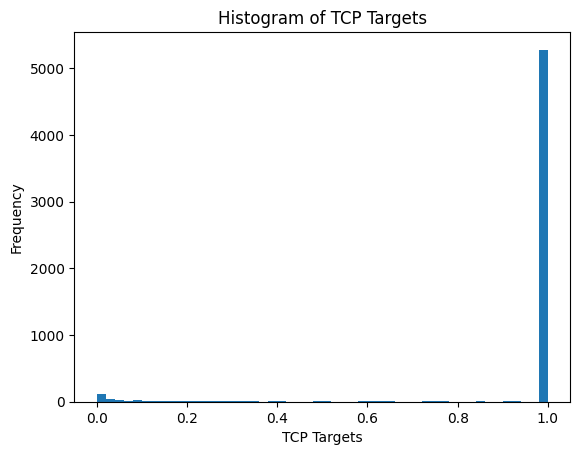

In [62]:
data = np.load('/Users/anushka/Documents/Summer-Project-/dataset/labeled_embeddings_probs_and_labels_v2.npz')
embeddings = data['test_embeddings']
probs = data['probs']
y_true = data['y_train']
y_hat = np.argmax(probs, axis=1)
p_y_hat = np.max(probs, axis=1)
y_true_class = np.argmax(data['y_train'], axis=1) 
p_y_star = np.sum(probs * y_true, axis=1)
#tcp targets
tcp_targets= p_y_star/ p_y_hat

plt.hist(tcp_targets, bins=50)
plt.xlabel('TCP Targets')
plt.ylabel('Frequency')
plt.title('Histogram of TCP Targets')
plt.show()



In [63]:
def compute_tcp_star_targets(y_true_class, y_hat, p_y_star, p_y_hat, alpha):
    indicator = (y_true_class != y_hat).astype(float)
    numerator = p_y_star
    denominator = p_y_hat + (indicator * (p_y_star + alpha))
    tcp_star_targets = numerator / denominator
    return tcp_star_targets

tcp_star_targets = compute_tcp_star_targets(y_true_class, y_hat, p_y_star, p_y_hat, alpha=0.3)

X= embeddings
y = tcp_star_targets

In [64]:

from sklearn.model_selection import train_test_split
import numpy as np

# correctness labels: 1 for correct, 0 for incorrect
is_correct_full = (y_hat == y_true_class).astype(int)

# stratified split to keep same success/error ratio
train_indices, test_indices = train_test_split(
    np.arange(len(embeddings)),
    test_size=0.2,
    random_state=42,
    stratify=is_correct_full
)

# check counts
train_success = np.sum(is_correct_full[train_indices] == 1)
train_error   = np.sum(is_correct_full[train_indices] == 0)
test_success  = np.sum(is_correct_full[test_indices] == 1)
test_error    = np.sum(is_correct_full[test_indices] == 0)

print(f"Train: {train_success} successes, {train_error} errors")
print(f"Test:  {test_success} successes, {test_error} errors")


Train: 4220 successes, 341 errors
Test:  1056 successes, 85 errors


In [65]:
# Use the split indices
X_train = embeddings[train_indices]
y_train = tcp_targets[train_indices]
y_hat_train = y_hat[train_indices]
y_true_class_train = y_true_class[train_indices]

X_test = embeddings[test_indices]
y_test = tcp_targets[test_indices]
y_hat_test = y_hat[test_indices]
y_true_class_test = y_true_class[test_indices]



In [66]:

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Determine which are errors/successes on the training split
is_correct_train = (y_hat_train == y_true_class_train)
X_train_errors = X_train_tensor[~is_correct_train]
y_train_errors = y_train_tensor[~is_correct_train]

X_train_success = X_train_tensor[is_correct_train]
y_train_success = y_train_tensor[is_correct_train]

print(f"Errors in train: {len(X_train_errors)}, Successes in train: {len(X_train_success)}")

X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test, dtype=torch.float32)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

from torch.utils.data import Dataset, DataLoader

class Custom_Loader(Dataset):
    def __init__(self, X_success, y_success, X_error, y_error,
                 success_ratio=0.75, batch_size=128, augment_fn=None):
        self.X_success = X_success
        self.y_success = y_success
        self.X_error = X_error
        self.y_error = y_error
        self.success_ratio = success_ratio
        self.batch_size = batch_size
        self.augment_fn = augment_fn

        self.n_success = int(self.batch_size * self.success_ratio)
        self.n_error = self.batch_size - self.n_success
        self.num_batches = min(
            len(self.X_success) // self.n_success,
            len(self.X_error) // self.n_error
        )

    def __len__(self):
        return self.num_batches

    def __getitem__(self, idx):
        success_idx = torch.randperm(len(self.X_success))[:self.n_success]
        error_idx = torch.randperm(len(self.X_error))[:self.n_error]

        Xb = torch.cat([self.X_success[success_idx], self.X_error[error_idx]], dim=0)
        yb = torch.cat([self.y_success[success_idx], self.y_error[error_idx]], dim=0)

        perm = torch.randperm(len(Xb))
        Xb = Xb[perm]
        yb = yb[perm]

        if self.augment_fn:
            Xb = self.augment_fn(Xb)

        return Xb, yb

train_dataset = Custom_Loader(
    X_train_success, y_train_success,
    X_train_errors, y_train_errors,
    success_ratio=0.75,
    batch_size=128,
    #augment_fn=add_gaussian_noise  
)
train_loader = DataLoader(train_dataset, batch_size=None, shuffle=False)
model = ConfidenceNet(input_dim=X_train.shape[1])
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.MSELoss()

error_batch_size = 64   # number of errors per batch
success_batch_size = 64 # number of successes per batch

# Number of success and error batches
num_success_batches = len(X_train_success) // success_batch_size
num_error_batches = len(X_train_errors) // error_batch_size

error_pointer = 0  # where we are in the error list

for epoch in range(500):
    model.train()
    train_losses = []

    # Shuffle successes and errors at the start of each epoch
    perm_success = torch.randperm(len(X_train_success))
    perm_errors = torch.randperm(len(X_train_errors))

    X_success_shuffled = X_train_success[perm_success]
    y_success_shuffled = y_train_success[perm_success]
    X_errors_shuffled = X_train_errors[perm_errors]
    y_errors_shuffled = y_train_errors[perm_errors]

    for i in range(num_success_batches):
        # Pick next n errors
        error_start = error_pointer
        error_end = error_start + error_batch_size

        if error_end > len(X_errors_shuffled):
            # Wrap around
            overflow = error_end - len(X_errors_shuffled)
            X_error_batch = torch.cat([
                X_errors_shuffled[error_start:],
                X_errors_shuffled[:overflow]
            ])
            y_error_batch = torch.cat([
                y_errors_shuffled[error_start:],
                y_errors_shuffled[:overflow]
            ])
            error_pointer = overflow
        else:
            X_error_batch = X_errors_shuffled[error_start:error_end]
            y_error_batch = y_errors_shuffled[error_start:error_end]
            error_pointer = error_end

        # Get successes for this batch
        success_start = i * success_batch_size
        success_end = success_start + success_batch_size
        X_success_batch = X_success_shuffled[success_start:success_end]
        y_success_batch = y_success_shuffled[success_start:success_end]

        # Combine and shuffle within batch
        X_batch = torch.cat([X_success_batch, X_error_batch])
        y_batch = torch.cat([y_success_batch, y_error_batch])
        perm = torch.randperm(X_batch.size(0))
        X_batch = X_batch[perm]
        y_batch = y_batch[perm]

        # Forward + backward
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = sum(train_losses) / len(train_losses)
    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.6f}")

model.eval()
with torch.no_grad():
    Xall_tensor = torch.tensor(X_test, dtype=torch.float32)
    confidence_scores_tcpr_augmented_test = model(Xall_tensor).cpu().numpy() 


Errors in train: 341, Successes in train: 4220
Epoch 01 | Train Loss: 0.136294
Epoch 02 | Train Loss: 0.098629
Epoch 03 | Train Loss: 0.079458
Epoch 04 | Train Loss: 0.067811
Epoch 05 | Train Loss: 0.061564
Epoch 06 | Train Loss: 0.053101
Epoch 07 | Train Loss: 0.047189
Epoch 08 | Train Loss: 0.047093
Epoch 09 | Train Loss: 0.038576
Epoch 10 | Train Loss: 0.034939
Epoch 11 | Train Loss: 0.037097
Epoch 12 | Train Loss: 0.032380
Epoch 13 | Train Loss: 0.032399
Epoch 14 | Train Loss: 0.027769
Epoch 15 | Train Loss: 0.026525
Epoch 16 | Train Loss: 0.022879
Epoch 17 | Train Loss: 0.023585
Epoch 18 | Train Loss: 0.020253
Epoch 19 | Train Loss: 0.024002
Epoch 20 | Train Loss: 0.018607
Epoch 21 | Train Loss: 0.019196
Epoch 22 | Train Loss: 0.017853
Epoch 23 | Train Loss: 0.018974
Epoch 24 | Train Loss: 0.017106
Epoch 25 | Train Loss: 0.017374
Epoch 26 | Train Loss: 0.015923
Epoch 27 | Train Loss: 0.014987
Epoch 28 | Train Loss: 0.014236
Epoch 29 | Train Loss: 0.012334
Epoch 30 | Train Loss: 0.

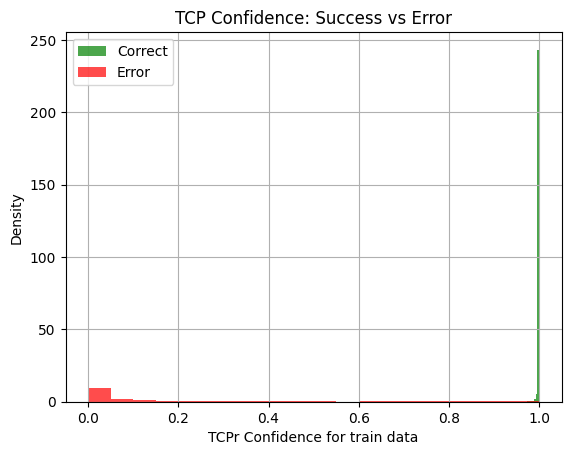

In [67]:
model.eval()
with torch.no_grad():
    Xall_tensor = torch.tensor(X_train, dtype=torch.float32)
    confidence_scores_tcp = model(Xall_tensor).cpu().numpy()

is_correct_train = (y_hat_train == y_true_class_train)
success_conf = confidence_scores_tcp[is_correct_train]
error_conf = confidence_scores_tcp[~is_correct_train]

plt.hist(success_conf, bins=20, density=True, alpha=0.7, label='Correct', color='green')
plt.hist(error_conf, bins=20, density=True, alpha=0.7, label='Error', color='red')
plt.xlabel('TCPr Confidence for train data')
plt.ylabel('Density')
plt.title('TCP Confidence: Success vs Error')
plt.legend()
plt.grid(True)
plt.show()

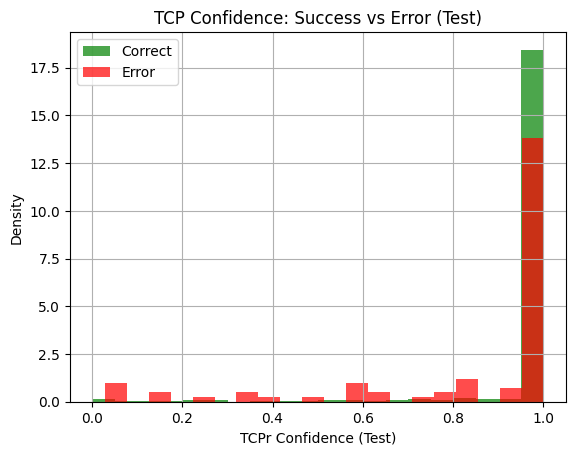

In [68]:
model.eval()
with torch.no_grad():
    Xall_tensor = torch.tensor(X_test, dtype=torch.float32)
    confidence_scores_tcp_test = model(Xall_tensor).cpu().numpy()

is_correct_test = (y_hat_test == y_true_class_test)
success_conf = confidence_scores_tcp_test[is_correct_test]
error_conf = confidence_scores_tcp_test[~is_correct_test]

plt.hist(success_conf, bins=20, density=True, alpha=0.7, label='Correct', color='green')
plt.hist(error_conf, bins=20, density=True, alpha=0.7, label='Error', color='red')
plt.xlabel('TCPr Confidence (Test)')
plt.ylabel('Density')
plt.title('TCP Confidence: Success vs Error (Test)')
plt.legend()
plt.grid(True)
plt.show()

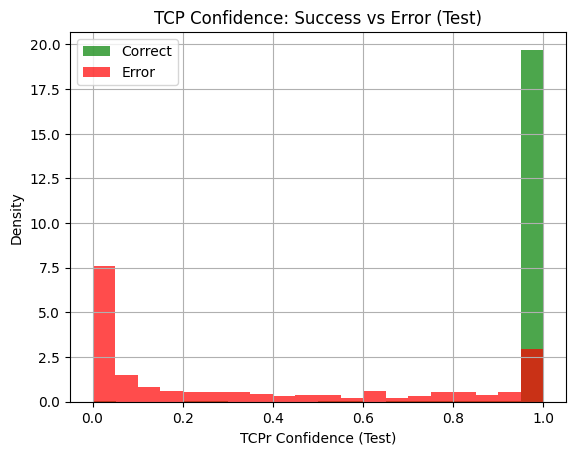

In [69]:
model.eval()
with torch.no_grad():
    Xall_tensor = torch.tensor(embeddings, dtype=torch.float32)
    confidence_scores_tcp = model(Xall_tensor).cpu().numpy()

is_correct = (y_hat == y_true_class)
success_conf = confidence_scores_tcp[is_correct]
error_conf = confidence_scores_tcp[~is_correct]

plt.hist(success_conf, bins=20, density=True, alpha=0.7, label='Correct', color='green')
plt.hist(error_conf, bins=20, density=True, alpha=0.7, label='Error', color='red')
plt.xlabel('TCPr Confidence (Test)')
plt.ylabel('Density')
plt.title('TCP Confidence: Success vs Error (Test)')
plt.legend()
plt.grid(True)
plt.show()